In [1]:
import random as rnd
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import PolynomialFeatures
import matplotlib as mpl
import matplotlib.pyplot as plt
import random as rnd
import numpy as np
from numpy import random as rnd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import cv2 as cv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [2]:
mnist = fetch_openml('mnist_784' , version=1)
X, Y = mnist['data'].values , mnist['target'].to_numpy()
X = X.astype(np.ubyte)
print(X.shape)
def view_random_pic(set_x, set_y, stop_indx):
    rand_indx = rnd.randint(0,stop_indx)
    print('random_index: ' , rand_indx)
    
    samp_y = set_y[rand_indx]
    samp_x = set_x[rand_indx]
    size = int(samp_x.shape[0]**0.5)
    samp_x = samp_x.reshape((size,size))
    _ = plt.imshow(samp_x, cmap = 'binary')
    plt.show()
    print( 'label: ' , samp_y )

(70000, 784)


In [3]:
## Augmentation
augmentation_chance = 0.35
translation_range = [-1,1]
rotation_range = [-3,3]
scale_range = [0.9,1.1]
X_aug = []
y_aug = []

for i, img in enumerate(X):
    X_aug.append(np.copy(img))
    y_aug.append(Y[i])

    if np.random.random() <= augmentation_chance:
        img = img.reshape(28,28)
        trans_mat = np.float32(
            [[1,0, np.random.randint(translation_range[0],translation_range[1])],
             [0,1, np.random.randint(translation_range[0],translation_range[1])]]
        )
        rand_scale = (np.random.random() * 0.2) + 0.8
        rotation_mat = cv.getRotationMatrix2D((14,14), np.random.randint(*rotation_range), rand_scale)
    
        img = cv.warpAffine(img,trans_mat,(28,28))
        img = cv.warpAffine(img,rotation_mat,(28,28))
        img = img.reshape(-1)
        X_aug.append(np.copy(img))
        y_aug.append(Y[i])

X = np.array(X_aug)
Y = np.array(y_aug)

In [4]:
## Perform Zoneing
window_size = (2,2)
img_size = (28,28)
X_new = []
for i, img in enumerate(X_aug):
    img = img.reshape(img_size[0]//window_size[0], window_size[0], -1, window_size[1]).swapaxes(1,2).reshape(-1, window_size[0], window_size[1])
    img = img.reshape((img_size[0]//window_size[0])**2,window_size[0]*window_size[0])
    X_new.append(img.mean(axis = 1))

X = np.array(X_new)
print(X.shape)

(94412, 196)


random_index:  51488


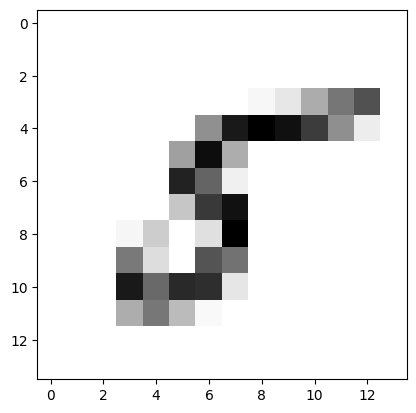

label:  5


In [5]:
view_random_pic(X, Y, X.shape[0])

In [6]:
## Perform PCA
pca = PCA(n_components=30)
X = pca.fit_transform(X)

## Add the combination of attributes
poly_features = PolynomialFeatures(degree = 2 , interaction_only = False, include_bias = True)
X = poly_features.fit_transform(X)

## Normalize
scaler = StandardScaler()
X = scaler.fit_transform(X)

print(X.shape)

(94412, 496)


In [7]:
# Cleaning the data and creating test and train
Y = Y.astype(np.uint8)

# determin a seed:
seed = 69

#create random indexes based on seed
np.random.seed(seed)
random_indexes = np.arange(0,70000)
np.random.shuffle(random_indexes)

#the split ratio of test_train
ratio = 0.8
stop_indx = int(ratio * 70000)
print(f'Train: 0 - {stop_indx} \t Test: {stop_indx} - 69999')

X_train, X_test = X[random_indexes][:stop_indx] , X[random_indexes][stop_indx:]
Y_train, Y_test = Y[random_indexes][:stop_indx] , Y[random_indexes][stop_indx:]

Train: 0 - 56000 	 Test: 56000 - 69999


In [8]:
#Classifier
sgd_clf = SGDClassifier(
    loss = 'perceptron',
    random_state = 420,
    penalty = 'elasticnet',
    max_iter = 1500,
    n_jobs = -1
)

sgd_clf.fit(X_train , Y_train)

SGDClassifier(loss='perceptron', max_iter=1500, n_jobs=-1, penalty='elasticnet',
              random_state=420)

In [9]:
# perform cross-validationX_test_sc751-800 in 2024. Q.
cvs_sgd = cross_val_score(sgd_clf, X_train, Y_train, cv = 5, scoring = 'accuracy')
print(cvs_sgd.mean())

0.9635


In [10]:
## Check the test set
y_true = Y_test
y_pred_perceptron = sgd_clf.predict(X_test)

In [13]:
acc_per = accuracy_score(y_true , y_pred_perceptron)

conf_mat_per = confusion_matrix(y_true , y_pred_perceptron)
print(f'Perceptron Acc: {acc_per*100}%')

n_conf_mat_per = conf_mat_per / conf_mat_per.sum(axis = 1, keepdims = True)

np.fill_diagonal(n_conf_mat_per , 0)


Perceptron Acc: 96.65%


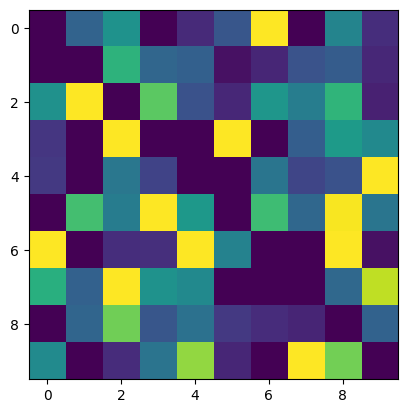

In [12]:
plt.imshow(minmax_scale(n_conf_mat_per, (0,255)))